In [1]:
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
from pybedtools import BedTool
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from scipy.spatial.distance import pdist, squareform
from plot_params import *
basedir= Path('/home/hsher/scratch/ABC_2rep/')
out_stem = 'K562_rep6'
#fl='/home/hsher/scratch/K562_rep4.count.csv'

In [2]:
raw_counts = pd.read_csv(basedir/'counts'/'repeats'/'megatables'/'name'/f'{out_stem}.tsv.gz', sep = '\t', index_col = 0)

In [3]:
genome_counts = pd.read_csv(basedir/'counts'/'genome'/'megatables'/f'{out_stem}.tsv.gz', sep = '\t')
genome_counts.index = genome_counts.index+1

In [4]:
megaoutputs = pd.read_csv(basedir/'DMM_repeat'/'name'/f'{out_stem}.megaoutputs.tsv', sep = '\t', index_col = 0)
megaoutputs_genome = pd.read_csv(basedir/'DMM'/f'{out_stem}.megaoutputs.tsv', sep = '\t')
megaoutputs_genome.set_index('name', inplace = True)

# Visualize

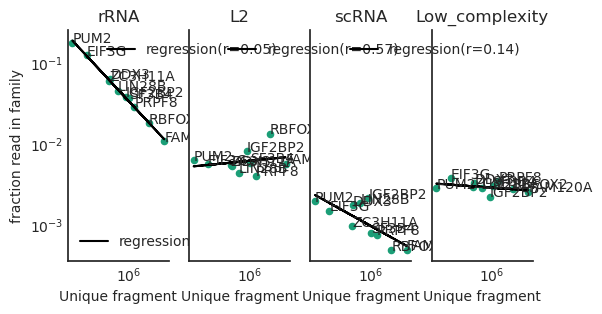

In [5]:

f, axes = plt.subplots(1,4, sharey = True, figsize = (6,3))
for family, ax in zip(['rRNA', 'L2', 'scRNA', 'Low_complexity'], axes): # 'snRNA', 'tRNA', 
    
    total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
    frac_table = pd.concat([total_reads, 
                            raw_counts.loc[megaoutputs.loc[megaoutputs['repFamily']==family].index].sum(axis = 0)/total_reads],
              axis = 1)
    frac_table.columns = ['#total reads', f'fraction in {family} family']
    
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {family} family']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    frac_table.plot.scatter(x = '#total reads', y = f'fraction in {family} family', ax = ax)
    for index, row in frac_table.iterrows():
        ax.text(row['#total reads'], row[f'fraction in {family} family'], index.split('.')[1])

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel('fraction read in family')
    ax.set_title(family)
sns.despine()
plt.savefig(figdir/'family_regression.pdf')

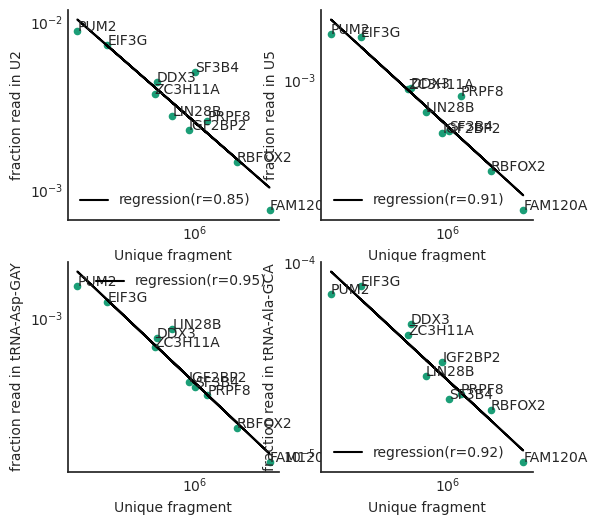

In [6]:
f, axes = plt.subplots(2,2, figsize = (6,6))
for gene, ax in zip(['U2', 'U5', 'tRNA-Asp-GAY', 'tRNA-Ala-GCA'], axes.flatten()):#'tRNA-Tyr-TAC'
    
    total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
    frac_table = pd.concat([total_reads, 
                            raw_counts.loc[gene]/total_reads],
              axis = 1)
    frac_table.columns = ['#total reads', f'fraction in {gene}']

    frac_table.plot.scatter(x = '#total reads', y = f'fraction in {gene}', ax = ax)
    for index, row in frac_table.iterrows():
        ax.text(row['#total reads'], row[f'fraction in {gene}'], index.split('.')[1])
    
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {gene}']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel(f'fraction read in {gene}')
sns.despine()
plt.savefig(figdir/'U2_U5_regression.pdf')

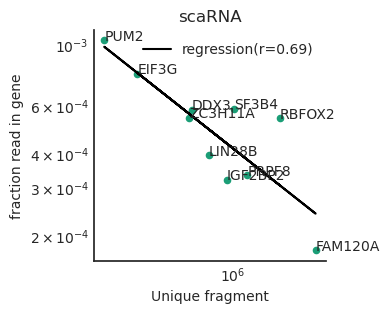

In [7]:
f, ax = plt.subplots(1,1, figsize = (3,3))
family = 'scaRNA'
total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
frac_table = pd.concat([total_reads, 
                    genome_counts.loc[
                        megaoutputs_genome.loc[megaoutputs_genome['transcript_type_top'].str.contains(family)].index].sum(axis = 0)/total_reads],
      axis = 1)
frac_table.columns = ['#total reads', f'fraction in {family}']
frac_table = frac_table.loc[frac_table[f'fraction in {family}']>0]
frac_table.plot.scatter(x = '#total reads', y = f'fraction in {family}', ax = ax)
for index, row in frac_table.iterrows():
    ax.text(row['#total reads'], row[f'fraction in {family}'], index.split('.')[1])
    
if not frac_table.empty:
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {family}']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)

    #coef_df.append(['genome:'+family, reg_score, coef[0,0], intercept[0]])
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel('fraction read in gene')
    ax.set_title(family)
    sns.despine()

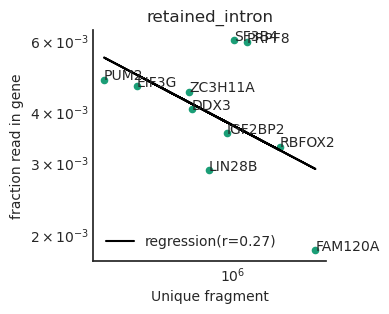

In [8]:
f, ax = plt.subplots(1,1, figsize = (3,3))
family = 'retained_intron'
total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
frac_table = pd.concat([total_reads, 
                    genome_counts.loc[
                        megaoutputs_genome.loc[megaoutputs_genome['transcript_type_top'].str.contains(family)].index].sum(axis = 0)/total_reads],
      axis = 1)
frac_table.columns = ['#total reads', f'fraction in {family}']
frac_table = frac_table.loc[frac_table[f'fraction in {family}']>0]
frac_table.plot.scatter(x = '#total reads', y = f'fraction in {family}', ax = ax)
for index, row in frac_table.iterrows():
    ax.text(row['#total reads'], row[f'fraction in {family}'], index.split('.')[1])
    
if not frac_table.empty:
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {family}']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)

    #coef_df.append(['genome:'+family, reg_score, coef[0,0], intercept[0]])
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel('fraction read in gene')
    ax.set_title(family)
    sns.despine()

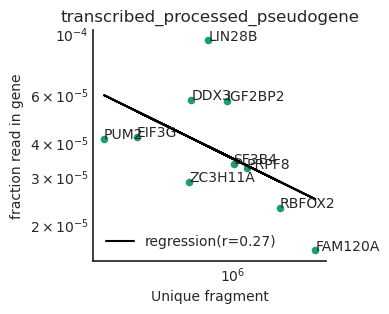

In [9]:
f, ax = plt.subplots(1,1, figsize = (3,3))
family = 'transcribed_processed_pseudogene'
total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
frac_table = pd.concat([total_reads, 
                    genome_counts.loc[
                        megaoutputs_genome.loc[megaoutputs_genome['transcript_type_top'].str.contains(family)].index].sum(axis = 0)/total_reads],
      axis = 1)
frac_table.columns = ['#total reads', f'fraction in {family}']
frac_table = frac_table.loc[frac_table[f'fraction in {family}']>0]
frac_table.plot.scatter(x = '#total reads', y = f'fraction in {family}', ax = ax)
for index, row in frac_table.iterrows():
    ax.text(row['#total reads'], row[f'fraction in {family}'], index.split('.')[1])
    
if not frac_table.empty:
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {family}']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)

    #coef_df.append(['genome:'+family, reg_score, coef[0,0], intercept[0]])
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel('fraction read in gene')
    ax.set_title(family)
    sns.despine()

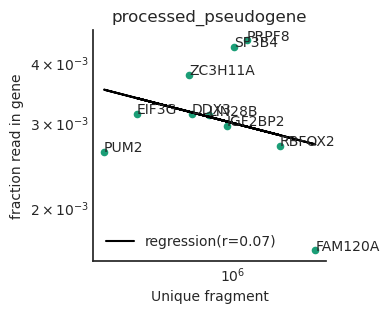

In [10]:
f, ax = plt.subplots(1,1, figsize = (3,3))
family = 'processed_pseudogene'
total_reads = raw_counts.sum(axis=0)+genome_counts.sum(axis = 0)
frac_table = pd.concat([total_reads, 
                    genome_counts.loc[
                        megaoutputs_genome.loc[megaoutputs_genome['transcript_type_top'].str.contains(family)].index].sum(axis = 0)/total_reads],
      axis = 1)
frac_table.columns = ['#total reads', f'fraction in {family}']
frac_table = frac_table.loc[frac_table[f'fraction in {family}']>0]
frac_table.plot.scatter(x = '#total reads', y = f'fraction in {family}', ax = ax)
for index, row in frac_table.iterrows():
    ax.text(row['#total reads'], row[f'fraction in {family}'], index.split('.')[1])
    
if not frac_table.empty:
    X=np.log(frac_table[['#total reads']])
    y=np.log(frac_table[[f'fraction in {family}']])
    reg = LinearRegression().fit(X,y)
    reg_score=reg.score(X,y)
    coef=reg.coef_
    intercept=reg.intercept_
    y_hat = reg.predict(X)

    #coef_df.append(['genome:'+family, reg_score, coef[0,0], intercept[0]])
    ax.plot(np.exp(X),np.exp(y_hat), label = f'regression(r={reg_score:.2f})', color = 'black')

    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel('Unique fragment')
    ax.set_ylabel('fraction read in gene')
    ax.set_title(family)
    sns.despine()